# **Fraudulent Card Transaction**

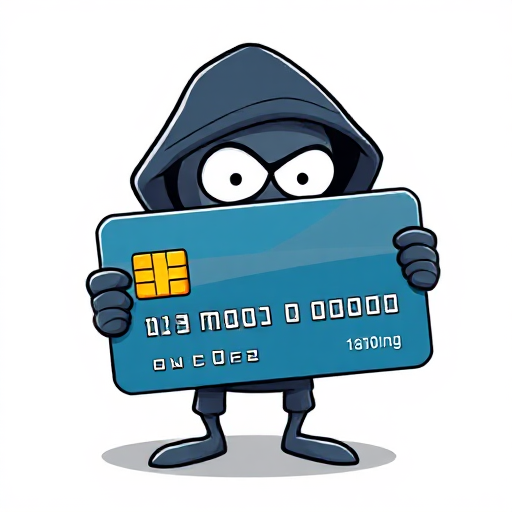

In this project, I built classification models to categorize customers as defaulters or non-defaulters based on information about their accounts and transactions. The dataset was provided by Capital One and is available on their GitHub page: Capital One Data Science Challenge.

The analysis includes data manipulation, data analysis, data modeling, and visualization, along with answering key business questions. The project is primarily implemented in Python, leveraging libraries such as NumPy, pandas, matplotlib, seaborn, and scikit-learn.

In [2]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.pipeline import make_pipeline

# Import libraries for model building
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.feature_selection import RFE


In [3]:
# read the data
data = pd.read_pickle("transactions.pkl", compression="infer")
data.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


In [4]:
# look at the last 5 rows of the dataset
data.tail()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
786358,732852505,732852505,50000.0,48904.96,2016-12-22T18:44:12,119.92,Lyft,US,US,90,...,,1095.04,,,,False,,,False,False
786359,732852505,732852505,50000.0,48785.04,2016-12-25T16:20:34,18.89,hulu.com,US,US,09,...,,1214.96,,,,False,,,False,False
786360,732852505,732852505,50000.0,48766.15,2016-12-27T15:46:24,49.43,Lyft,US,US,02,...,,1233.85,,,,False,,,False,False
786361,732852505,732852505,50000.0,48716.72,2016-12-29T00:30:55,49.89,walmart.com,US,US,09,...,,1283.28,,,,False,,,False,False
786362,732852505,732852505,50000.0,48666.83,2016-12-30T20:10:29,72.18,Uber,US,US,05,...,,1333.17,,,,False,,,False,False


The datasets contain 29 columns and 786363 transcations from 2106-08-12 to the end of 2016. Column isFraud contains the target value with true means fraud and false means not fraud.

In [6]:
# check the number of missing values and the type of the columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  object 
 1   customerId                786363 non-null  object 
 2   creditLimit               786363 non-null  float64
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  object 
 10  posConditionCode          786363 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

Data Structure:
To better understand the dataset, the columns are categorized as follows:
1.	Customer-Account-Related Columns:
- accountNumber: Unique identifier for the customer's account.
- customerId: Unique identifier for the customer.
- creditLimit: Maximum credit limit of the customer.
- availableMoney: Amount of money available for the customer.
- currentBalance: Current balance in the customer’s account.
- currentExpDate: Current expiration date of the card.
- accountOpenDate: Date when the account was opened.
- dateOfLastAddressChange: Last date when the customer's address was updated.
2.	Transaction-Related Columns:
- transactionDateTime: Timestamp of the transaction.
- transactionAmount: Amount spent in the transaction.
- acqCountry: Country of the acquiring bank.
- transactionType: Type of transaction.
- posEntryMode: Point of Sale (POS) entry mode.
- posConditionCode: Condition of the transaction at POS.
- posOnPremises: Indicates if the transaction occurred on the merchant's premises.
- recurringAuthInd: Indicator for recurring transactions.
- expirationDateKeyInMatch: Indicates whether the entered expiration date matches the system's key (True/False).
3.	Card Information:
- cardPresent: Whether the card was present during the transaction (True/False).
- cardCVV: Card Verification Value.
- enteredCVV: CVV entered during the transaction.
- cardLast4Digits: Last four digits of the card.
4.	Merchant Information:
- merchantName: Name of the merchant.
- merchantCountryCode: Country code of the merchant.
- merchantCategoryCode: Category code of the merchant.
- merchantCity: City where the merchant is located.
- merchantState: State where the merchant is located.
- merchantZip: ZIP code of the merchant's location.
5.	Other Columns:
- echoBuffer: Placeholder column (its specific role in the dataset is unclear).
6.	Target Column:
- isFraud: Binary column indicating whether a transaction is fraudulent (True/False).


In [7]:
# shape of the dataset
print(data.shape)
# change the type of the time column to datetime 
data['transactionDateTime'] = pd.to_datetime(data['transactionDateTime'])
# wheter dataset is balanced or not
print(data["isFraud"].value_counts(normalize = True) * 100 )

(786363, 29)
isFraud
False    98.420958
True      1.579042
Name: proportion, dtype: float64


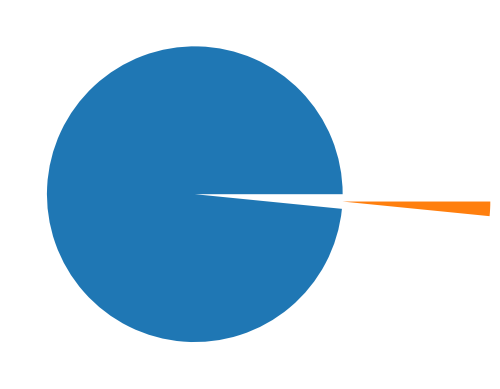

In [8]:
# plot the classes of the target 
target  = data["isFraud"].value_counts(normalize = True) * 100
plt.pie(target.values, target.index);

The dataset is highly unbalanced with 98.42% nonfraud and 1.58% fraud. 

In [10]:
# look at the description of numerical features
data.describe(include = "all").T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
accountNumber,786363,5000,380680241,32850,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customerId,786363,5000,380680241,32850,NaN,NaN,NaN,NaN,NaN,NaN,NaN
creditLimit,786363.0,NaN,NaN,NaN,10759.464459,250.0,5000.0,7500.0,15000.0,50000.0,11636.17489
availableMoney,786363.0,NaN,NaN,NaN,6250.725369,-1005.63,1077.42,3184.86,7500.0,50000.0,8880.783989
transactionDateTime,786363,NaN,NaN,NaN,2016-07-06 01:58:58.395681536,2016-01-01 00:01:02,2016-04-06 19:35:07,2016-07-08 05:03:57,2016-10-05 13:52:03.500000,2016-12-30 23:59:45,NaN
transactionAmount,786363.0,NaN,NaN,NaN,136.985791,0.0,33.65,87.9,191.48,2011.54,147.725569
merchantName,786363,2490,Uber,25613,NaN,NaN,NaN,NaN,NaN,NaN,NaN
acqCountry,786363,5,US,774709,NaN,NaN,NaN,NaN,NaN,NaN,NaN
merchantCountryCode,786363,5,US,778511,NaN,NaN,NaN,NaN,NaN,NaN,NaN
posEntryMode,786363,6,05,315035,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Cleaning 

These are the summary of steps to have a cleaner data :

1.  Columns with Blank or Missing Values:
- Some columns contain blank values instead of NaN, requiring cleaning. Columns with all blank values (e.g., ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd']) do not provide any useful data and will be dropped.
- Columns with fewer than 10% blank values: 
- acqCountry: 0.58% fill with ‘other’  
- merchantCountryCode: 0.092% fill with ‘other’  
- posEntryMode: 0.516% fill with ‘other’  
- posConditionCode: 0.052% fill with other  
- transactionType: 0.089% fill with other  
2. The columns accountNumber and customerId contain identical data, so accountNumber will be dropped.
3. A new column ‘cvvMatch’ will be created to indicate whether the cardCVV differs from the enteredCVV, after this, the columns cardCVV and enteredCVV will be dropped.
4. Columns with a high number of categories
- ["merchantName", "merchantCategoryCode", "customerId", "cardLast4Digits"] have a high number of categories. Also, customerId and cardLast4Digits do not have predictivity power. So I drop these two columns, and for the other columns, I only choose the top 5 categories and replace the other categories with Other. 


In [11]:
# check the total amont of nan values in the dataset
data.isnull().sum()

accountNumber               0
customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
echoBuffer                  0
currentBalance              0
merchantCity                0
merchantState               0
merchantZip                 0
cardPresent                 0
posOnPremises               0
recurringAuthInd            0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64

There is no missing values however some by analysing more we can see that some values are filled with blanks, so the dataset needs cleaning.

In [13]:
# check the amount on empty values in the dataset
def empty_value_sum(col):
    # return the total of rows with empty values
    return (data[col] == "").sum()
# the proprtion of empty value of each features
for col in data.columns:
    print(f"{col} ------> {round(empty_value_sum(col)/len(data),5)}")

accountNumber ------> 0.0
customerId ------> 0.0
creditLimit ------> 0.0
availableMoney ------> 0.0
transactionDateTime ------> 0.0
transactionAmount ------> 0.0
merchantName ------> 0.0
acqCountry ------> 0.0058
merchantCountryCode ------> 0.00092
posEntryMode ------> 0.00516
posConditionCode ------> 0.00052
merchantCategoryCode ------> 0.0
currentExpDate ------> 0.0
accountOpenDate ------> 0.0
dateOfLastAddressChange ------> 0.0
cardCVV ------> 0.0
enteredCVV ------> 0.0
cardLast4Digits ------> 0.0
transactionType ------> 0.00089
echoBuffer ------> 1.0
currentBalance ------> 0.0
merchantCity ------> 1.0
merchantState ------> 1.0
merchantZip ------> 1.0
cardPresent ------> 0.0
posOnPremises ------> 1.0
recurringAuthInd ------> 1.0
expirationDateKeyInMatch ------> 0.0
isFraud ------> 0.0


columns : ['echoBuffer', 'merchantCity','merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd' ] do not include any data, So I will drop them

In [15]:
# drop columns that do not have any values
data.drop(['echoBuffer', 'merchantCity','merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd' ], axis=1, inplace=True)

In [16]:
# check duplicated rows
data[data.duplicated()]

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud


In [17]:
# check the number of unique values in the dataset
data.nunique()

accountNumber                 5000
customerId                    5000
creditLimit                     10
availableMoney              521916
transactionDateTime         776637
transactionAmount            66038
merchantName                  2490
acqCountry                       5
merchantCountryCode              5
posEntryMode                     6
posConditionCode                 4
merchantCategoryCode            19
currentExpDate                 165
accountOpenDate               1820
dateOfLastAddressChange       2184
cardCVV                        899
enteredCVV                     976
cardLast4Digits               5246
transactionType                  4
currentBalance              487318
cardPresent                      2
expirationDateKeyInMatch         2
isFraud                          2
dtype: int64

In [18]:
# We have three binary columns, check their values
col_binary = ["cardPresent", "expirationDateKeyInMatch", "isFraud"]

for i in col_binary:
    print(f" {i} values are {data[i].unique()}")

 cardPresent values are [False  True]
 expirationDateKeyInMatch values are [False  True]
 isFraud values are [False  True]


In [20]:
# change the type of values from boolean to integers
for i in col_binary: 
    data[i] = data[i].astype(int) 

In [21]:
# whether accountNumber and customerId have the same values
assert(data.accountNumber == data.customerId).all()

We can see that accountNumber and customerId have the same data, so I can drop one of these columns. 

In [23]:
# wheter cardCVV and enteredCVV have the same values
assert(data.cardCVV == data.enteredCVV).all()

AssertionError: 

I will build a new column that shows whether the card CVV is different from entered CVV, and will drop cardCVV and enteredCVV

In [25]:
# create a new column the check the difference between cardCVV and enteredCVV
data["cvvMatch"] = (data.cardCVV == data.enteredCVV).astype(int)

In [27]:
# drop columns 'cardCVV', 'enteredCVV','accountNumber'
data.drop(['cardCVV', 'enteredCVV','accountNumber'], axis=1, inplace=True)

### Exploratoray Analysis

In [29]:
# look at categorical columns
col_cat = data.select_dtypes(include=['object', 'bool']).columns
col_cat

Index(['customerId', 'merchantName', 'acqCountry', 'merchantCountryCode',
       'posEntryMode', 'posConditionCode', 'merchantCategoryCode',
       'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange',
       'cardLast4Digits', 'transactionType'],
      dtype='object')

In [31]:
fraud_Data = data[data["isFraud"]==True]
fraud_Data[col_cat].head(3)

,customerId,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardLast4Digits,transactionType
694,984504651,Walgreens #860120,US,US,09,08,health,10/2021,2015-07-27,2016-06-25,8332,PURCHASE
971,114896048,sears.com,US,US,09,01,online_retail,09/2028,2015-12-19,2015-12-19,8915,PURCHASE
1072,114896048,Planet Fitness #136615,US,US,09,01,health,05/2028,2015-12-19,2015-12-19,8915,PURCHASE


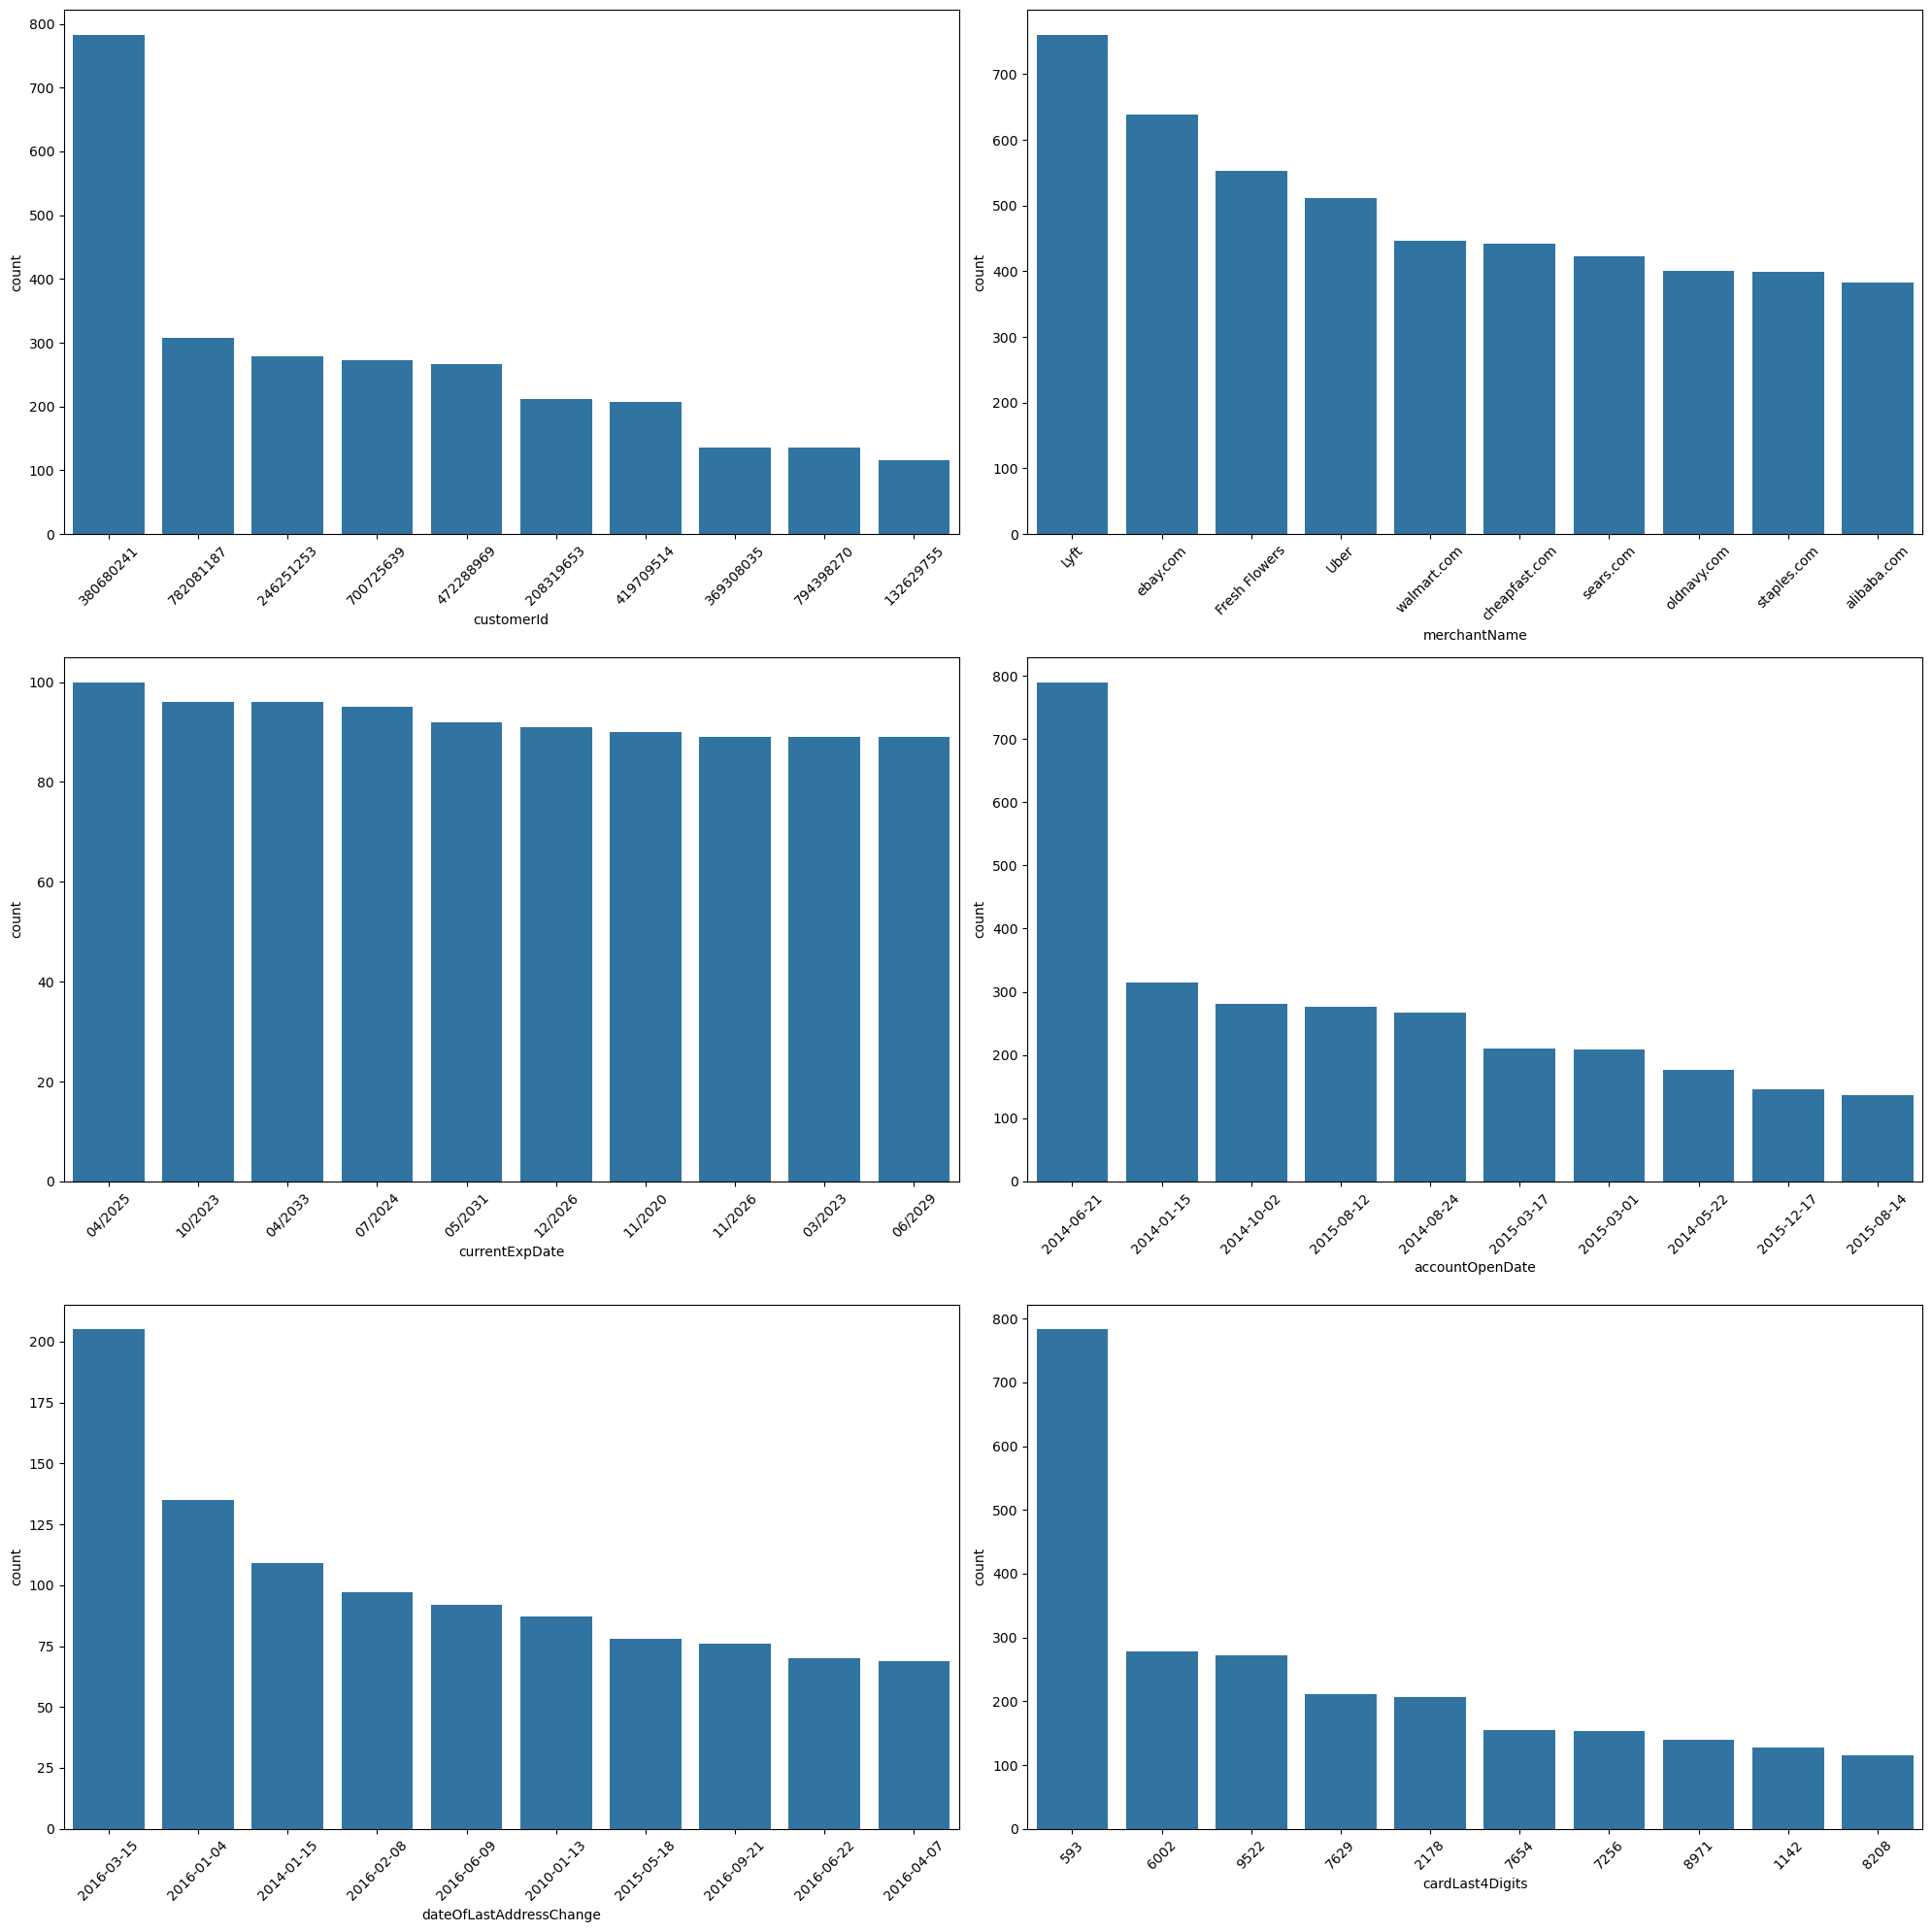

In [33]:
category_col_1 = [ 'customerId', 'merchantName',  
       'currentExpDate', 'accountOpenDate','dateOfLastAddressChange',  'cardLast4Digits']

fig, ax = plt.subplots(3, 2, figsize=(20, 20))

# Flatten the axes array to make indexing easier
ax = ax.flatten()

# Loop over each column in pay_col and plot the histograms
for i, col in enumerate(category_col_1):
    dt = pd.DataFrame(fraud_Data[col].value_counts().head(10))
    sns.barplot(x = dt.index, y = dt["count"],  ax = ax[i])
    ax[i].tick_params(axis='x', labelrotation = 45)
    

# Adjust layout for better readability
plt.tight_layout()
plt.show()

#### Cusromer Id Column Analysis

Question 1: Does fraud occur only among customers with a high number of transactions?

In [37]:
# customers with the highest number of transaction
data.customerId.value_counts().head(10)

customerId
380680241    32850
882815134    13189
570884863    10867
246251253    10172
369308035     7229
724518977     6283
894938833     6101
419709514     5930
832842201     5850
208319653     5235
Name: count, dtype: int64

Customer with the id 380680241 has the highest number of fraud.Lets look at some data related to this customer

In [40]:
high_fraud_id = data[(data['customerId'] == '380680241')]
print(f'the customer with id 380680241 has made {high_fraud_id.shape[0]} transaction')
high_fraud_id.groupby('isFraud').agg(merchantName = ('merchantName', 'nunique'), 
                                     transactionAmount = ('transactionAmount', 'sum'),
                                     merchantCountryCode = ('merchantCountryCode', 'nunique'),
                                    acqCountry = ('acqCountry', 'nunique'), 
                                    posEntryMode = ('posEntryMode', 'nunique'),
                                    posConditionCode = ('posConditionCode','nunique'), 
                                    cardPresent = ('cardPresent', 'nunique'),
                                    cvvMatch = ('cvvMatch','nunique'), 
                                    dateOfLastAddressChange = ('dateOfLastAddressChange','nunique'), 
                                    cardLast4Digits = ('cardLast4Digits','nunique'))

the customer with id 380680241 has made 32850 transaction


,merchantName,transactionAmount,merchantCountryCode,acqCountry,posEntryMode,posConditionCode,cardPresent,cvvMatch,dateOfLastAddressChange,cardLast4Digits
isFraud,,,,,,,,,,
0,366,4564405.15,5,5,6,4,2,2,89,1
1,13,200599.19,4,4,6,4,2,2,82,1


In [42]:
# rate of fraud for customers with highest number of transactions
id_cus = data.customerId.value_counts().index
filtered_data = data[data['customerId'].isin(id_cus)]
fraud_rate_id = filtered_data.groupby(['customerId', 'isFraud']).size().unstack(fill_value=0)
fraud_rate_id["total Transaction"] = fraud_rate_id[0] + fraud_rate_id[1]
fraud_rate_id['rate of fraud %'] = round((fraud_rate_id[1]/fraud_rate_id["total Transaction"])*100, 2)

fraud_rate_id.sort_values(by = "total Transaction" , ascending = False).head(10)

isFraud,0,1,total Transaction,rate of fraud %
customerId,,,,
380680241,32067,783,32850,2.38
882815134,13092,97,13189,0.74
570884863,10808,59,10867,0.54
246251253,9894,278,10172,2.73
369308035,7093,136,7229,1.88
724518977,6219,64,6283,1.02
894938833,6057,44,6101,0.72
419709514,5723,207,5930,3.49
832842201,5775,75,5850,1.28


In [43]:
# rate of fraud for  10 customers with lowest number of transaction
fraud_rate_id.sort_values(by = "total Transaction" , ascending = True).head(10)

isFraud,0,1,total Transaction,rate of fraud %
customerId,,,,
238928524,1,0,1,0.0
828800922,1,0,1,0.0
220057198,1,0,1,0.0
675656700,1,0,1,0.0
622138951,1,0,1,0.0
766427482,1,0,1,0.0
984589832,1,0,1,0.0
266636812,1,0,1,0.0
772075422,1,0,1,0.0


In [46]:
# customers with highest rate of fraud
fraud_rate_id.sort_values(by = "rate of fraud %" , ascending = False).head(10)

isFraud,0,1,total Transaction,rate of fraud %
customerId,,,,
356886744,0,2,2,100.00
749645399,0,1,1,100.00
666461201,1,1,2,50.00
494400203,2,2,4,50.00
275266909,2,1,3,33.33
938195288,79,35,114,30.70
319012201,5,2,7,28.57
336236533,13,5,18,27.78
838703913,154,58,212,27.36


It seems that there is not pattern between the number of transaction and the fraud transaction. 

In [49]:
customer_transaction_count = data.groupby('customerId').size()
data['total_trans_perCost'] = data['customerId'].map(customer_transaction_count)
data[['total_trans_perCost', 'isFraud']].corr(method='spearman')

,total_trans_perCost,isFraud
total_trans_perCost,1.0000,0.0183
isFraud,0.0183,1.0000


### Marchant Name

Question: Does a merchant have a higher potential to commit fraud?

In [53]:
# rate of fraud for customers with highest number of transactions
id_mechant = data.merchantName.value_counts().index
filtered_data = data[data['merchantName'].isin(id_mechant)]
fraud_count = filtered_data.groupby(['merchantName', 'isFraud']).size().unstack(fill_value=0)
fraud_count["total Transaction"] = fraud_count[0] + fraud_count[1]
fraud_count['rate of fraud %'] = round((fraud_count[1]/fraud_count["total Transaction"])*100, 2)

fraud_count.sort_values(by = "total Transaction" , ascending = False).head(10)

isFraud,0,1,total Transaction,rate of fraud %
merchantName,,,,
Uber,25101,512,25613,2.00
Lyft,24763,760,25523,2.98
oldnavy.com,16591,401,16992,2.36
staples.com,16581,399,16980,2.35
alibaba.com,16576,383,16959,2.26
apple.com,16541,357,16898,2.11
walmart.com,16427,446,16873,2.64
cheapfast.com,16416,442,16858,2.62
ebay.com,16203,639,16842,3.79


In [54]:
fraud_count.sort_values(by = "total Transaction" , ascending = True).head(10)

isFraud,0,1,total Transaction,rate of fraud %
merchantName,,,,
TMobile Wireless #602341,1,0,1,0.0
Curves #849125,1,0,1,0.0
EZ Wireless #149871,1,0,1,0.0
Runners #383214,2,0,2,0.0
Golds Gym #956354,2,0,2,0.0
Boost Mobile #104815,2,0,2,0.0
Sprint Communications #561941,2,0,2,0.0
Sprint Communications #606030,3,0,3,0.0
Golds Gym #970513,3,0,3,0.0


In [57]:
fraud_count.sort_values(by = "rate of fraud %" , ascending = False).head(10)

isFraud,0,1,total Transaction,rate of fraud %
merchantName,,,,
In-N-Out #949129,79,10,89,11.24
American Airlines,2844,295,3139,9.40
In-N-Out #863086,87,9,96,9.38
In-N-Out #463194,88,8,96,8.33
In-N-Out #422833,101,9,110,8.18
In-N-Out #567597,82,7,89,7.87
Walgreens #475572,26,2,28,7.14
In-N-Out #17755,95,7,102,6.86
Fresh Flowers,7781,553,8334,6.64


In [59]:
customer_transaction_count = data.groupby('merchantName').size()
data['total_trans_perMecrh'] = data['merchantName'].map(customer_transaction_count)
data[['total_trans_perMecrh', 'isFraud']].corr(method='spearman')

,total_trans_perMecrh,isFraud
total_trans_perMecrh,1.000000,0.053747
isFraud,0.053747,1.000000


The correlation matrix shows that the correlation between the total number of transactions per merchant (total_trans_perMerch) and fraud (isFraud) is low, with a value of 0.0537. This suggests that there is very little relationship between higher transaction volumes from a particular merchant and the likelihood of fraud. 

In [62]:
data.drop(['total_trans_perMecrh', 'total_trans_perCost'], axis=1, inplace=True)
data.shape

(786363, 21)

### Time related Columns

Regarding the time related columns I will calculate the time difference between each transactions and also the time diffrence between different columns.

In [66]:
# for each customer calculate the time difference between transactions
data = data.sort_values(by=['customerId', 'transactionDateTime'])
data['time_diff'] = data.groupby('customerId')['transactionDateTime'].diff().dt.total_seconds() / 60
data['time_diff'] = data['time_diff'].fillna(0)

In [68]:
data['accountOpenDate'] = pd.to_datetime(data['accountOpenDate'], format='%Y-%m-%d')
data["tand_time"] = pd.to_datetime(data["transactionDateTime"], format='%Y-%m-%d')
data['currentExpDate'] = pd.to_datetime(data['currentExpDate'], format='%m/%Y')
data['dateOfLastAddressChange'] = pd.to_datetime(data['dateOfLastAddressChange'], format='%Y-%m-%d')

In [70]:
# create time differece between trancaction time and account open date
data['diff_trans_openAc'] = (data['tand_time'] - data['accountOpenDate']).dt.days

# create time differece between trancaction time and currentExpDate
data['diff_trans_Exp'] = (data['tand_time'] - data['currentExpDate']).dt.days

# create time differece between trancaction time and dateOfLastAddressChange
data['diff_trans_addres'] = (data['tand_time'] - data['dateOfLastAddressChange']).dt.days

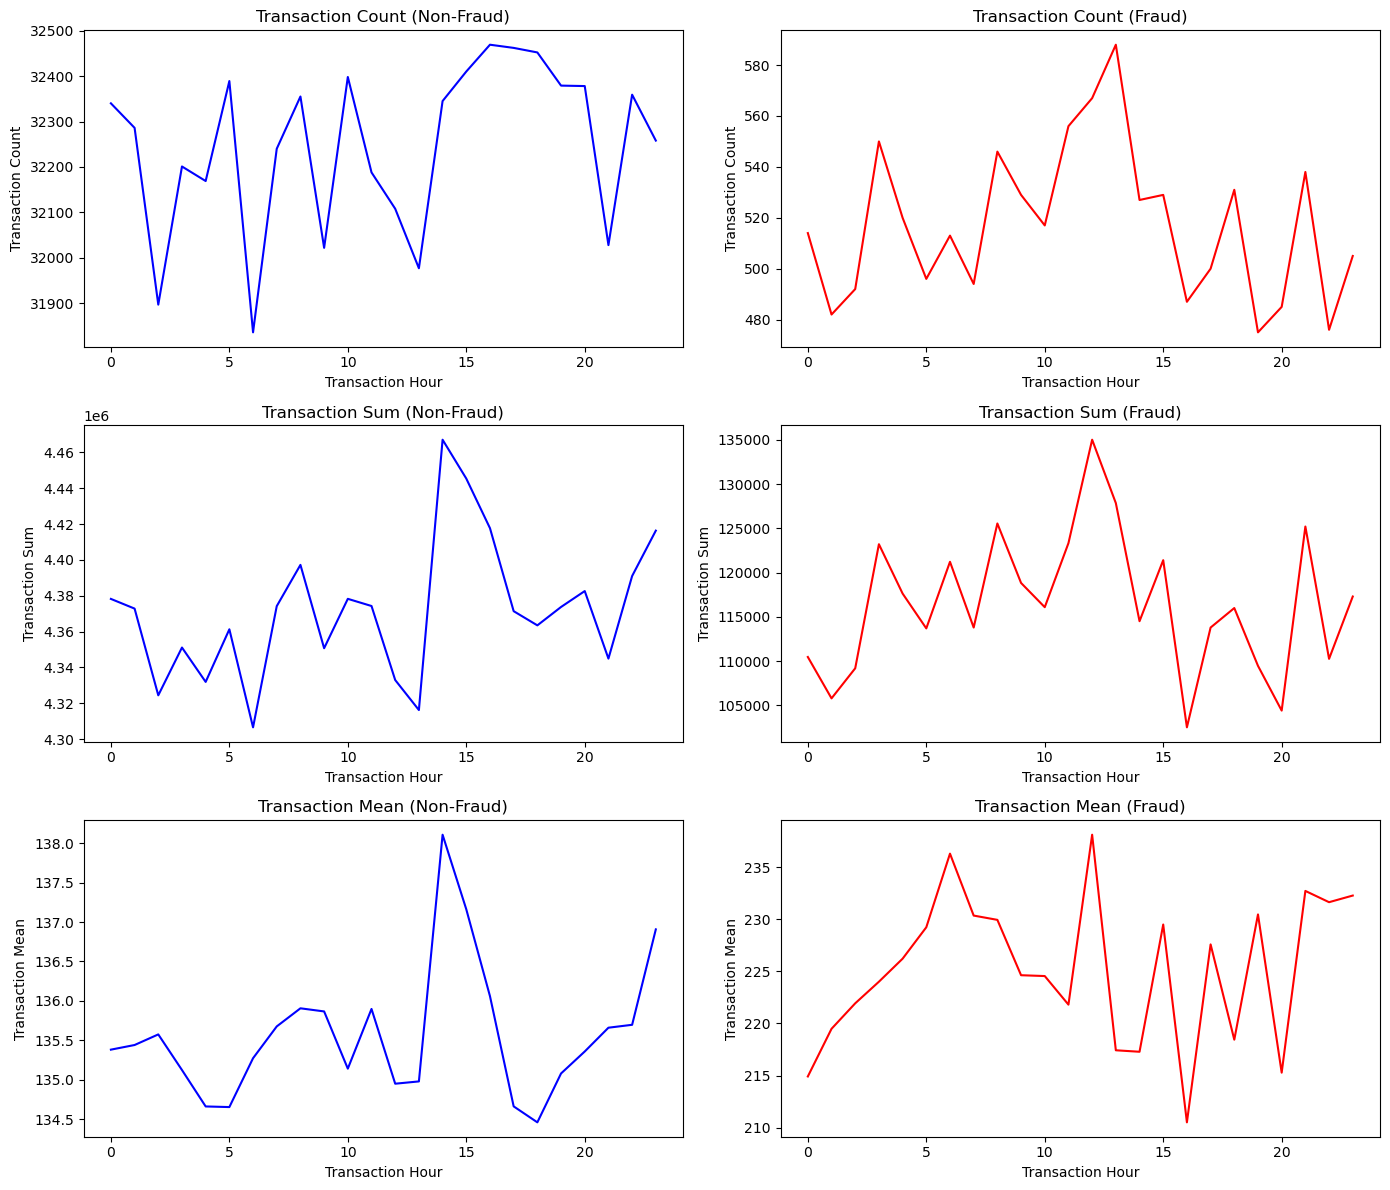

In [72]:
# transaction date time column
data['trans_month'] = data['transactionDateTime'].dt.month
data['trans_day'] = data['transactionDateTime'].dt.day
data['trans_hour'] = data['transactionDateTime'].dt.hour

hour_trans = data.groupby(['trans_hour', 'isFraud'])['transactionAmount'].aggregate(['count', 'sum','mean']).reset_index()
hour_trans_df = pd.DataFrame(hour_trans, columns = ['trans_hour', 'isFraud','count',  'sum','mean'])

# Set up a 3x2 grid for subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
metrics = ['count', 'sum', 'mean']
titles = ['Transaction Count', 'Transaction Sum', 'Transaction Mean']

# Plot for non-fraudulent transactions
for i, metric in enumerate(metrics):
    sns.lineplot(ax=axes[i, 0], x='trans_hour', y=metric, data=hour_trans_df.loc[hour_trans_df.isFraud == 0], color='blue')
    axes[i, 0].set_title(f"{titles[i]} (Non-Fraud)")
    axes[i, 0].set_xlabel("Transaction Hour")
    axes[i, 0].set_ylabel(titles[i])

# Plot for fraudulent transactions
for i, metric in enumerate(metrics):
    sns.lineplot(ax=axes[i, 1], x='trans_hour', y=metric, data=hour_trans_df.loc[hour_trans_df.isFraud == 1], color='red')
    axes[i, 1].set_title(f"{titles[i]} (Fraud)")
    axes[i, 1].set_xlabel("Transaction Hour")
    axes[i, 1].set_ylabel(titles[i])

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

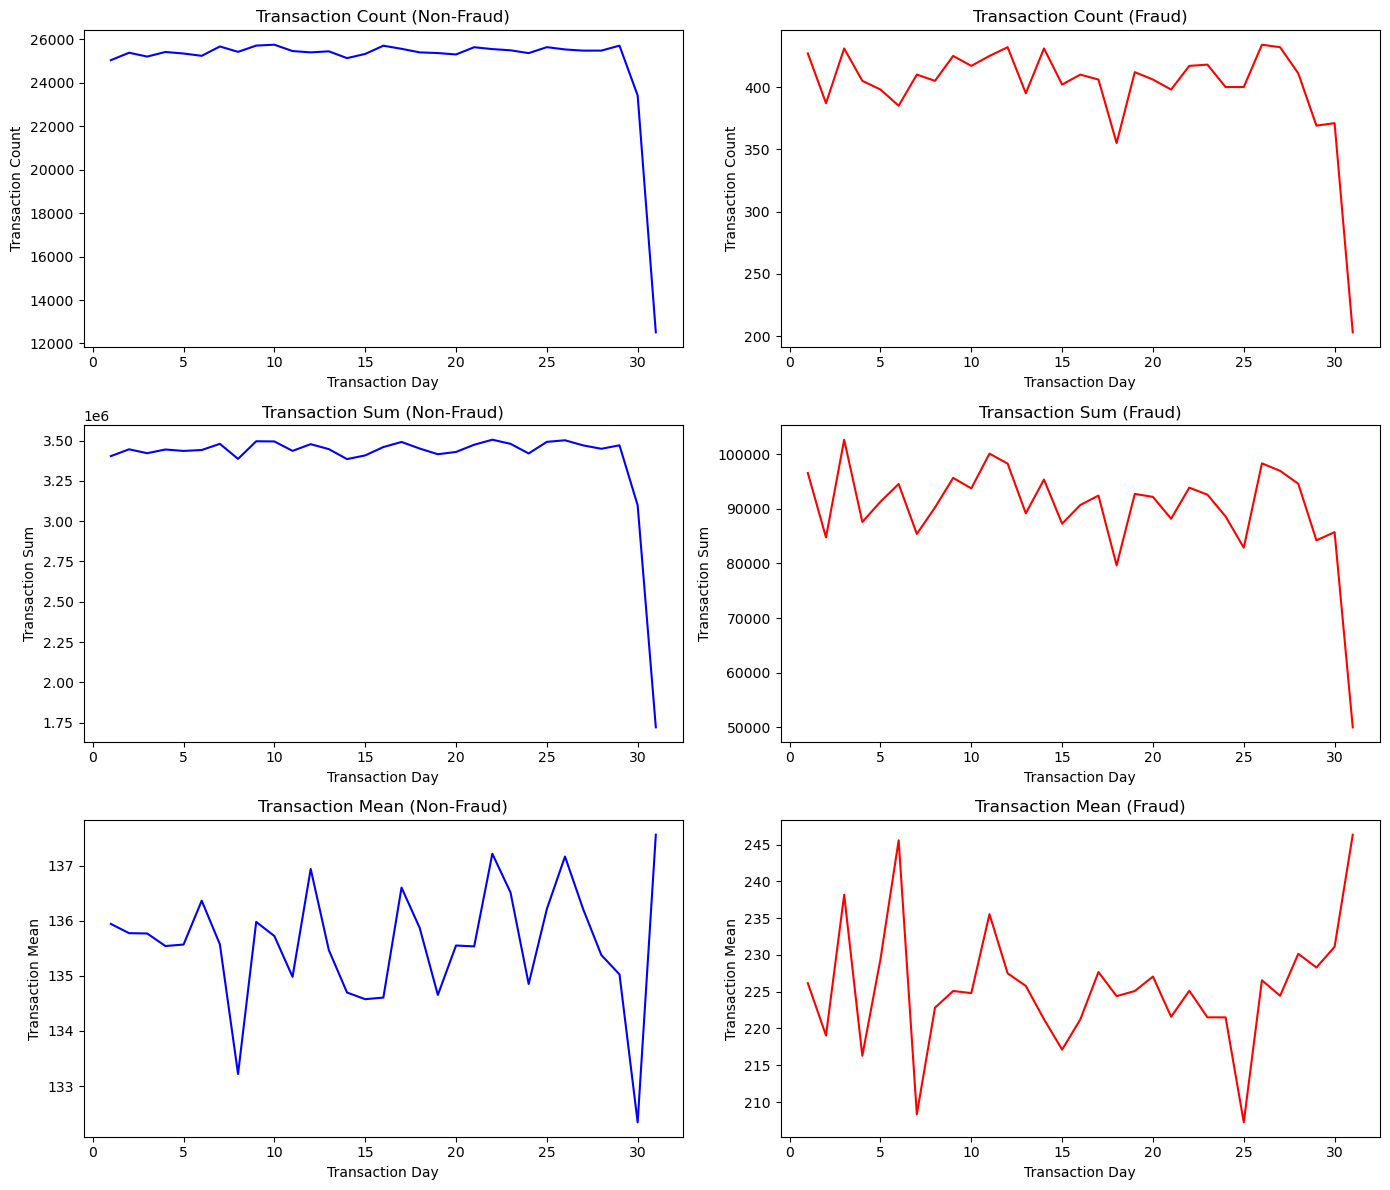

In [73]:
trans_day = data.groupby(['trans_day', 'isFraud'])['transactionAmount'].aggregate(['count', 'sum','mean']).reset_index()
trans_day_df = pd.DataFrame(trans_day, columns = ['trans_day', 'isFraud','count',  'sum','mean'])

# Set up a 3x2 grid for subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
metrics = ['count', 'sum', 'mean']
titles = ['Transaction Count', 'Transaction Sum', 'Transaction Mean']

# Plot for non-fraudulent transactions
for i, metric in enumerate(metrics):
    sns.lineplot(ax=axes[i, 0], x='trans_day', y=metric, data=trans_day_df.loc[trans_day_df.isFraud == 0], color='blue')
    axes[i, 0].set_title(f"{titles[i]} (Non-Fraud)")
    axes[i, 0].set_xlabel("Transaction Day")
    axes[i, 0].set_ylabel(titles[i])

# Plot for fraudulent transactions
for i, metric in enumerate(metrics):
    sns.lineplot(ax=axes[i, 1], x='trans_day', y=metric, data=trans_day_df.loc[trans_day_df.isFraud == 1], color='red')
    axes[i, 1].set_title(f"{titles[i]} (Fraud)")
    axes[i, 1].set_xlabel("Transaction Day")
    axes[i, 1].set_ylabel(titles[i])

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

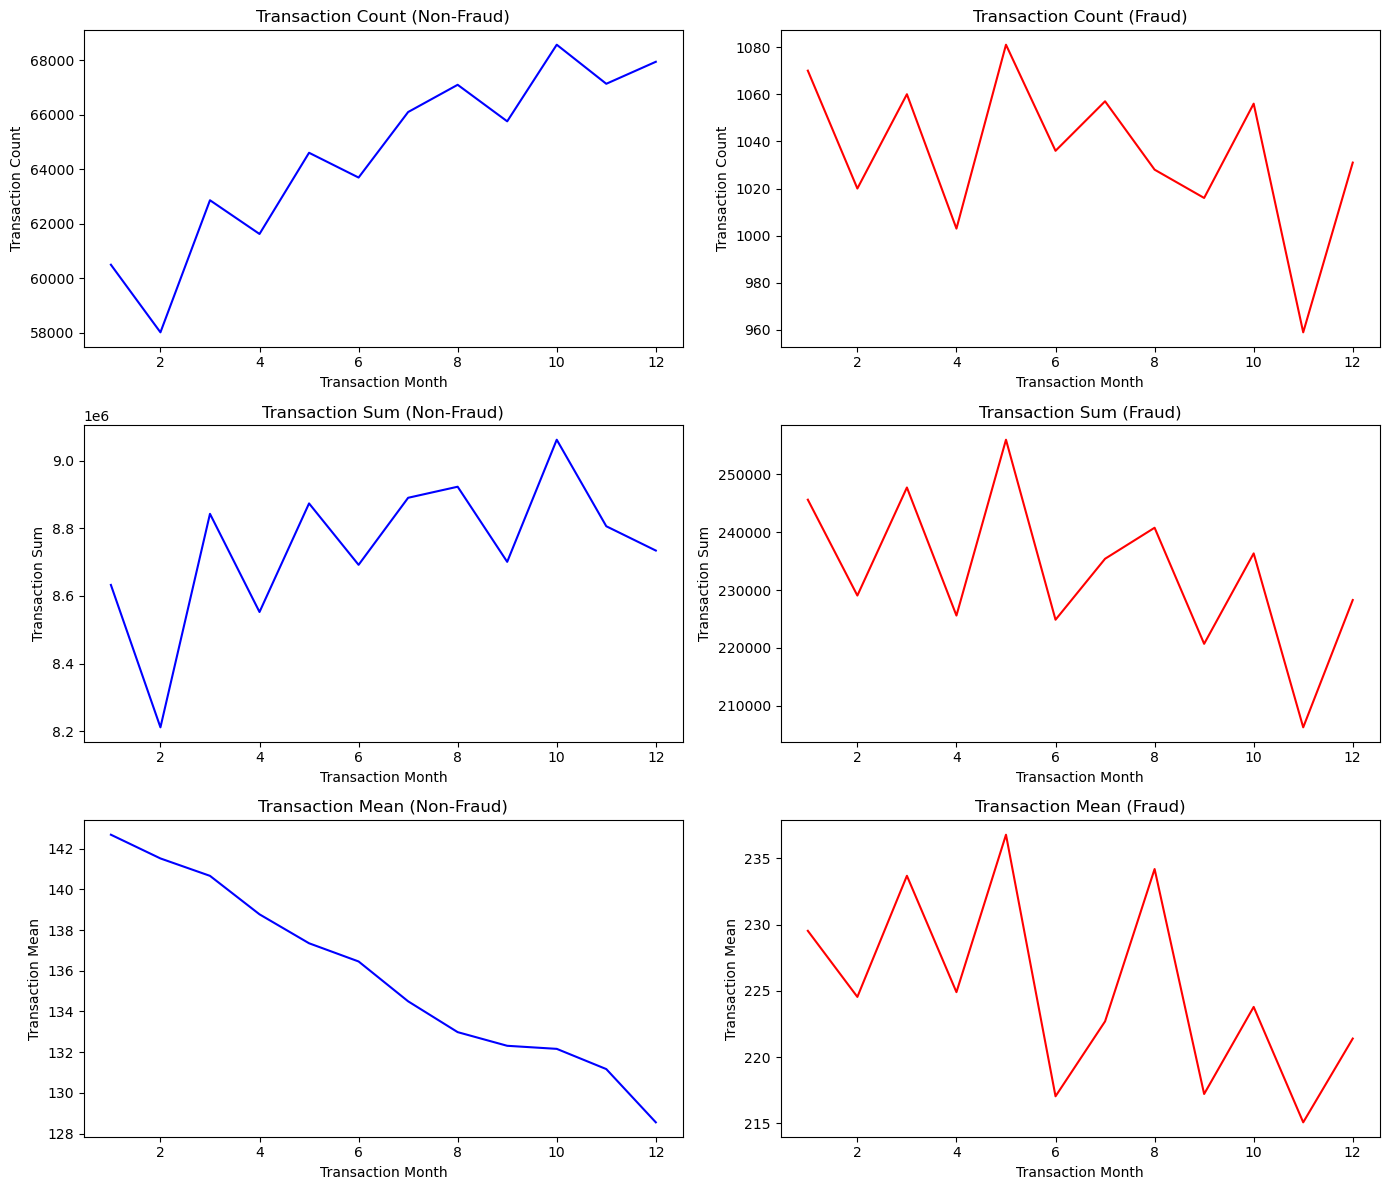

In [74]:
trans_month = data.groupby(['trans_month', 'isFraud'])['transactionAmount'].aggregate(['count', 'sum','mean']).reset_index()
trans_month_df = pd.DataFrame(trans_month, columns = ['trans_month', 'isFraud','count',  'sum','mean'])

# Set up a 3x2 grid for subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
metrics = ['count', 'sum', 'mean']
titles = ['Transaction Count', 'Transaction Sum', 'Transaction Mean']

# Plot for non-fraudulent transactions
for i, metric in enumerate(metrics):
    sns.lineplot(ax=axes[i, 0], x='trans_month', y=metric, data=trans_month_df.loc[trans_month_df.isFraud == 0], color='blue')
    axes[i, 0].set_title(f"{titles[i]} (Non-Fraud)")
    axes[i, 0].set_xlabel("Transaction Month")
    axes[i, 0].set_ylabel(titles[i])

# Plot for fraudulent transactions
for i, metric in enumerate(metrics):
    sns.lineplot(ax=axes[i, 1], x='trans_month', y=metric, data=trans_month_df.loc[trans_month_df.isFraud == 1], color='red')
    axes[i, 1].set_title(f"{titles[i]} (Fraud)")
    axes[i, 1].set_xlabel("Transaction Month")
    axes[i, 1].set_ylabel(titles[i])

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

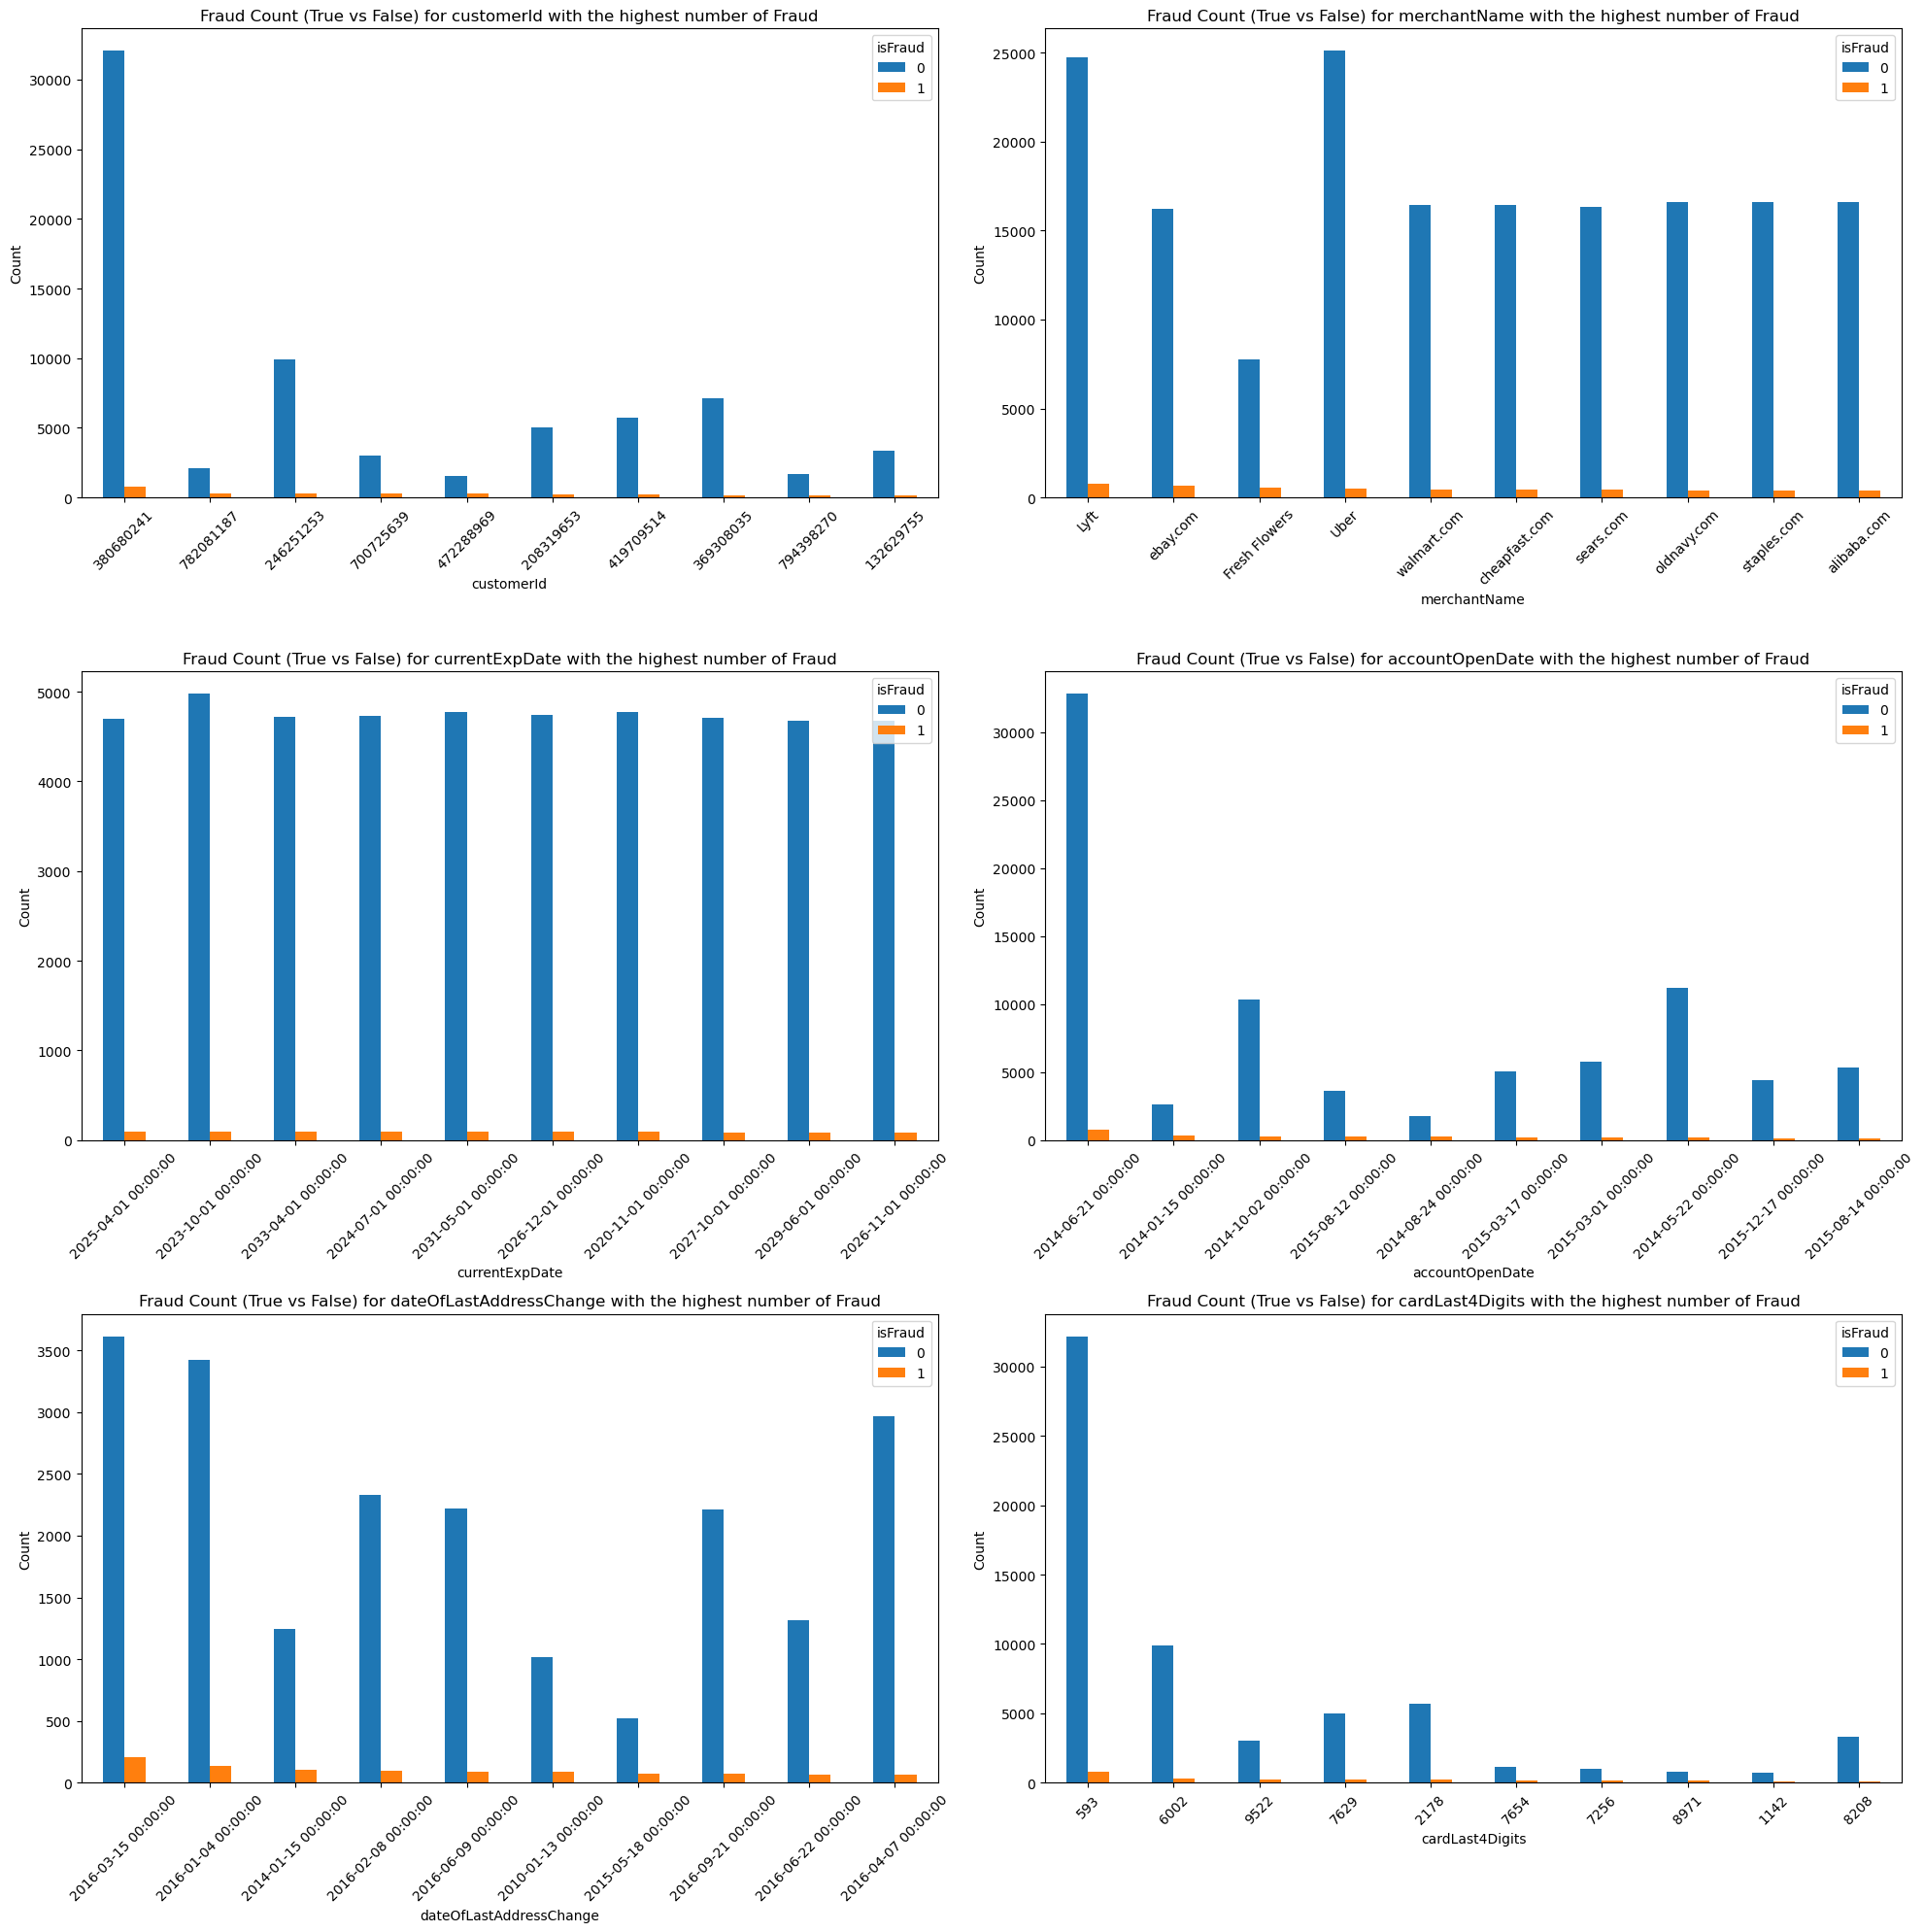

In [76]:
# look at the categorical columns of top 10 fraud values
fig, ax = plt.subplots(3, 2, figsize=(20, 20))
ax = ax.flatten()

# Loop through each column in category_col_1
for i, col in enumerate(category_col_1):
    # Group data by the category column and count fraud occurrences
    data_col_fraud = data[[col, 'isFraud']]
    data_grouped = data_col_fraud.groupby(col)["isFraud"].value_counts().unstack(fill_value=0)
    
    # Sort the data based on 'True' fraud counts and select top 10
    data_sorted = data_grouped.sort_values(by=1, ascending=False).head(10)
    
    # Plot the bar chart
    data_sorted.plot(kind="bar", stacked=False, ax=ax[i])
    
    # Set the labels and title
    ax[i].set_ylabel('Count')
    ax[i].set_xlabel(col)
    ax[i].set_title(f'Fraud Count (True vs False) for {col} with the highest number of Fraud')
    ax[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

### Categorical Columns with low number of categories in Fraud Classes

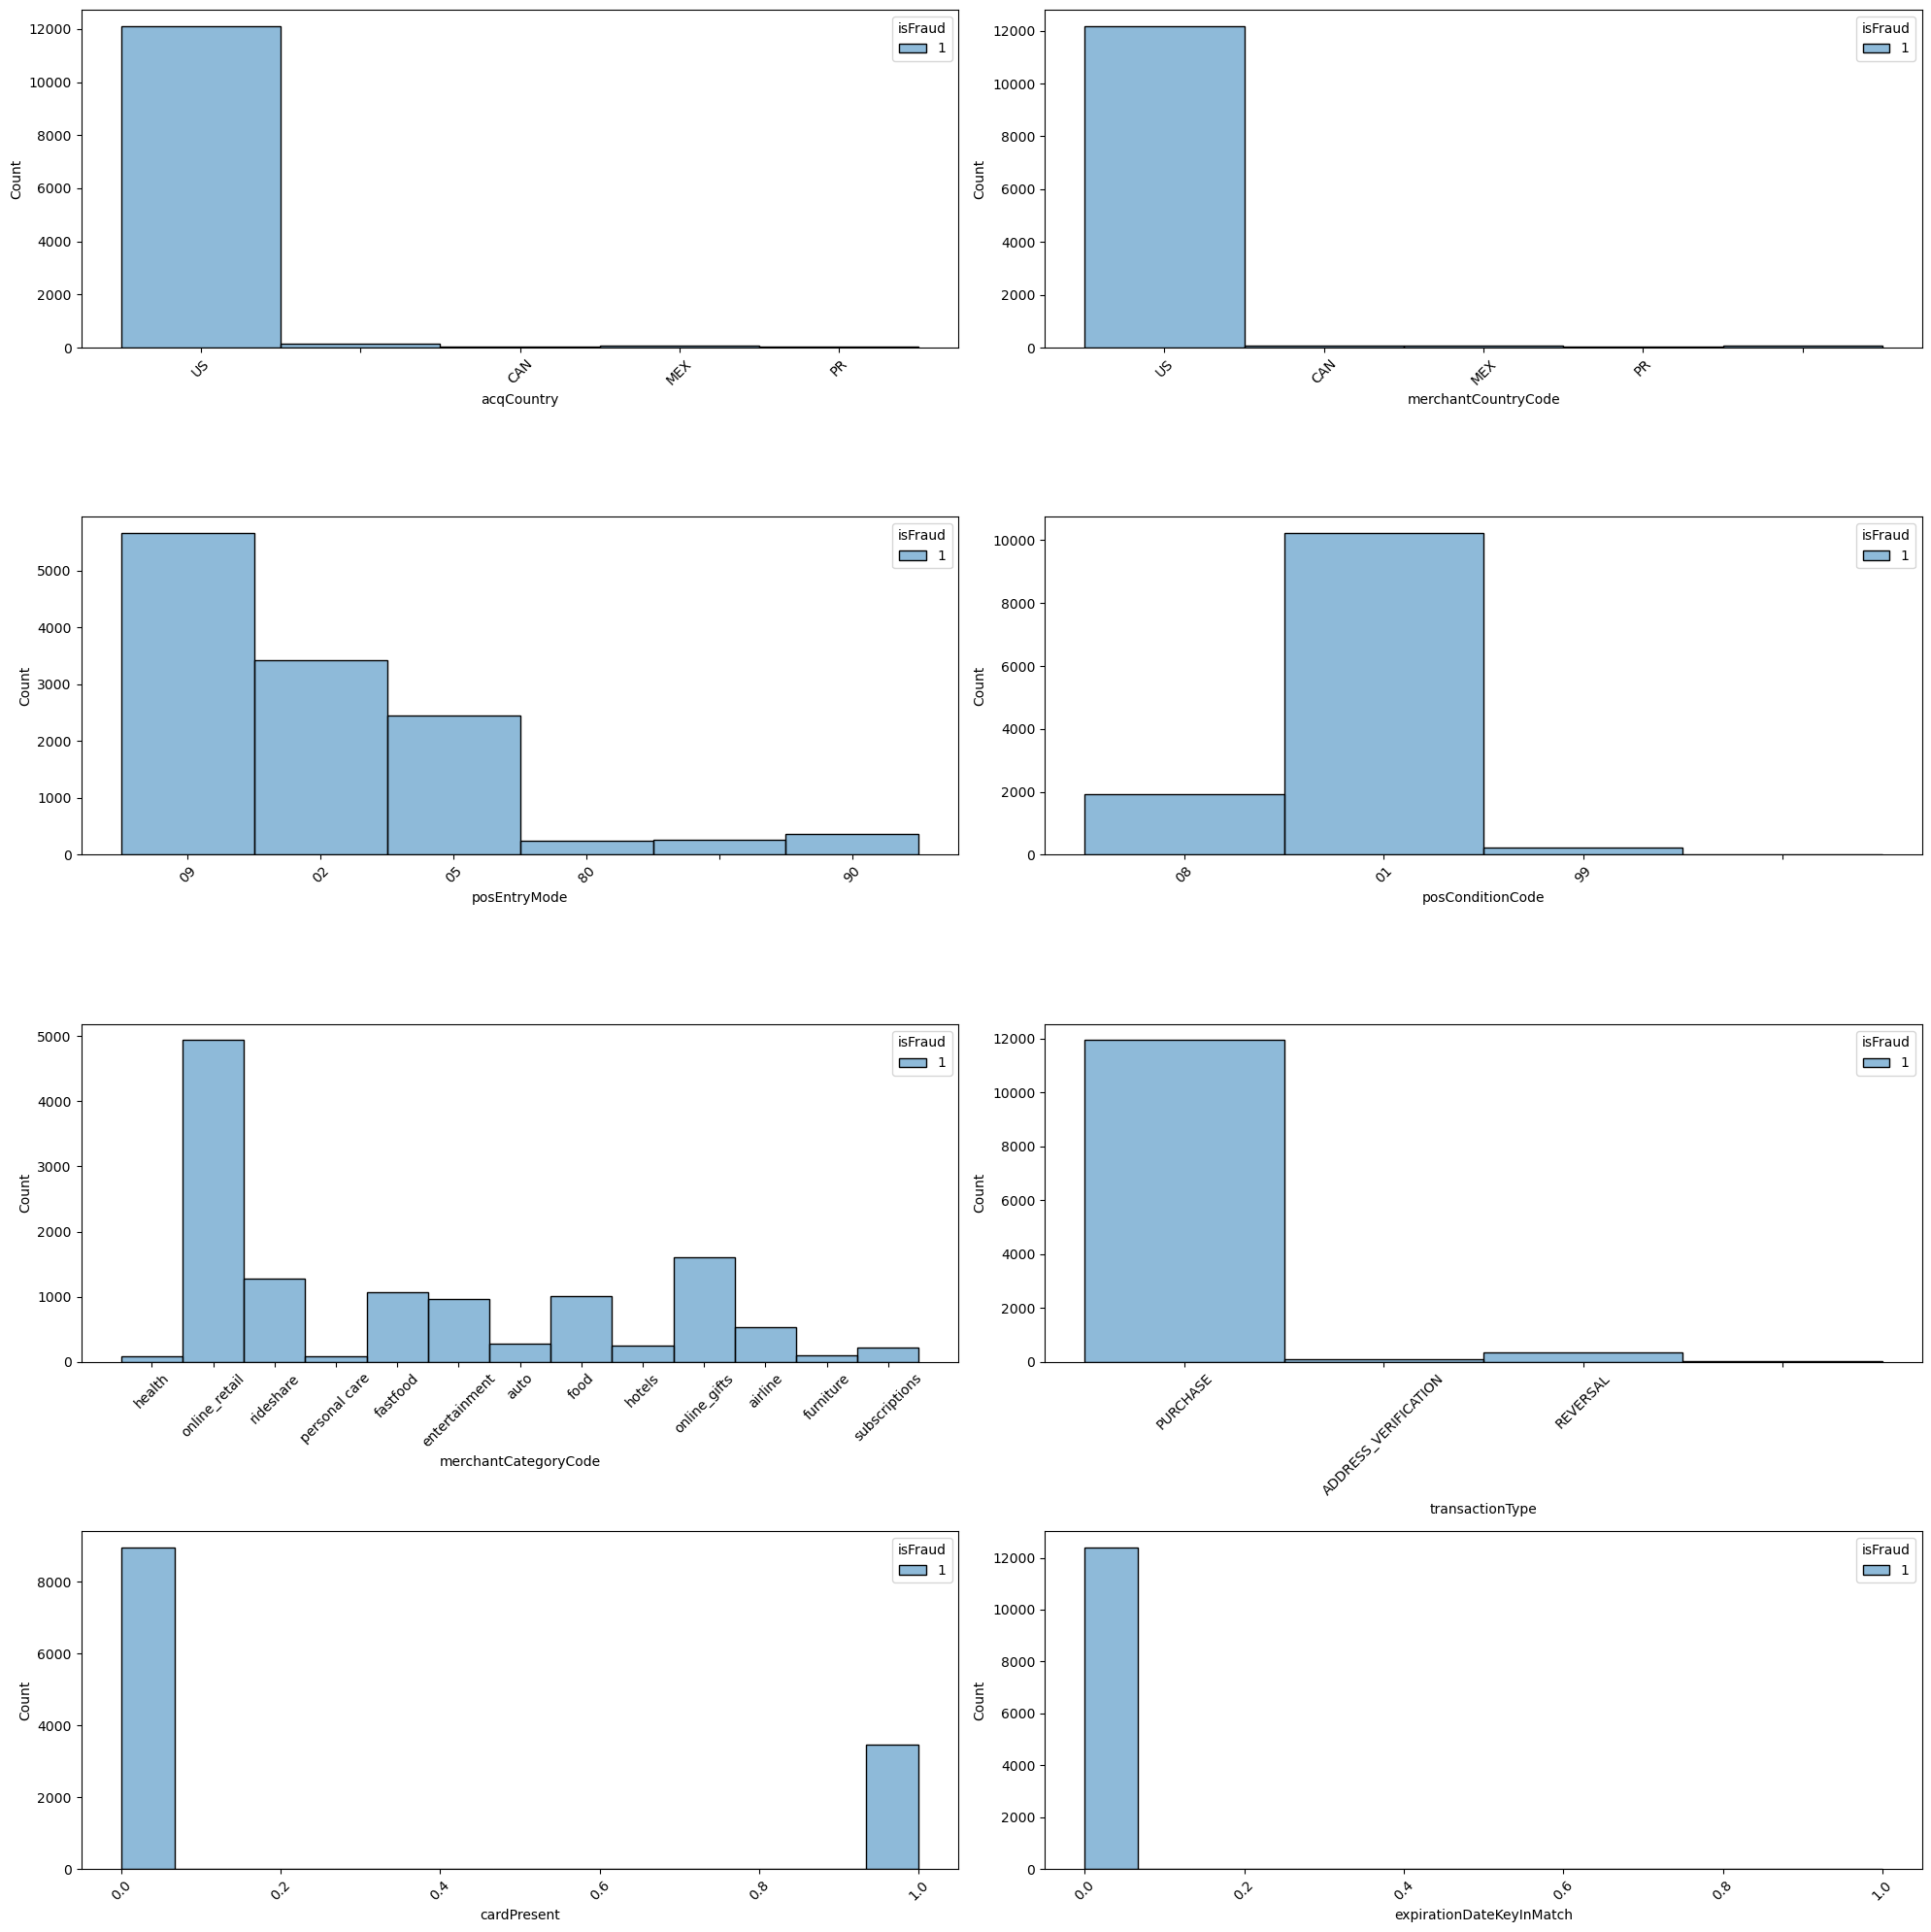

In [79]:
category_col = ['acqCountry','merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'transactionType', 'cardPresent', 'expirationDateKeyInMatch']
fig, ax = plt.subplots(4, 2, figsize=(20, 20))

# Flatten the axes array to make indexing easier
ax = ax.flatten()

# Loop over each column in pay_col and plot the histograms
for i, col in enumerate(category_col):
    sns.histplot(data=fraud_Data, x=col, ax = ax[i], hue = "isFraud")
    ax[i].tick_params(axis='x', labelrotation = 45)
    

# Adjust layout for better readability

plt.tight_layout()
plt.show()

In [80]:
for i in category_col:
    # filling missing value with other
    data[i] = data[i].replace("", "other")
    data_norm = pd.crosstab(data[i], data.isFraud, normalize='index',margins=True)
    data_norm.columns = ['Non-defaulted', 'Defaulted']
    
    data_count = pd.crosstab(data[i], data.isFraud, margins=True)
    data_count.columns = ['Non-defaulted', 'Defaulted', 'Total']
    
    combined = pd.concat([data_norm, data_count], keys=['Normalized', 'Count'], axis = 1)
    print(combined)

              Normalized                   Count                  
           Non-defaulted Defaulted Non-defaulted Defaulted   Total
acqCountry                                                        
CAN             0.977310  0.022690          2369        55    2424
MEX             0.979553  0.020447          3066        64    3130
PR              0.982445  0.017555          1511        27    1538
US              0.984353  0.015647        762587     12122  774709
other           0.967339  0.032661          4413       149    4562
All             0.984210  0.015790        773946     12417  786363
                       Normalized                   Count                  
                    Non-defaulted Defaulted Non-defaulted Defaulted   Total
merchantCountryCode                                                        
CAN                      0.976917  0.023083          2370        56    2426
MEX                      0.979637  0.020363          3079        64    3143
PR               

The plots indicate that these categories have higher frequencies, suggesting a greater likelihood of transactions being high-risk:

- rideshare followed by online_retail have a higher frequency of fraud.
- Transactions where the card is not present.
- Transactions where the expiration date key is not in March.
- Transactions of the "Other" type.
- Post entry mode is "Other."
- Post condition code is "Other."
- Acquiring country is "Other."
- Merchant country code is "Other."


### Numerical Categories

In [84]:
col_num = data.select_dtypes(include=['int32','int64', 'float64']).columns
col_num

Index(['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance',
       'cardPresent', 'expirationDateKeyInMatch', 'isFraud', 'cvvMatch',
       'time_diff', 'diff_trans_openAc', 'diff_trans_Exp', 'diff_trans_addres',
       'trans_month', 'trans_day', 'trans_hour'],
      dtype='object')

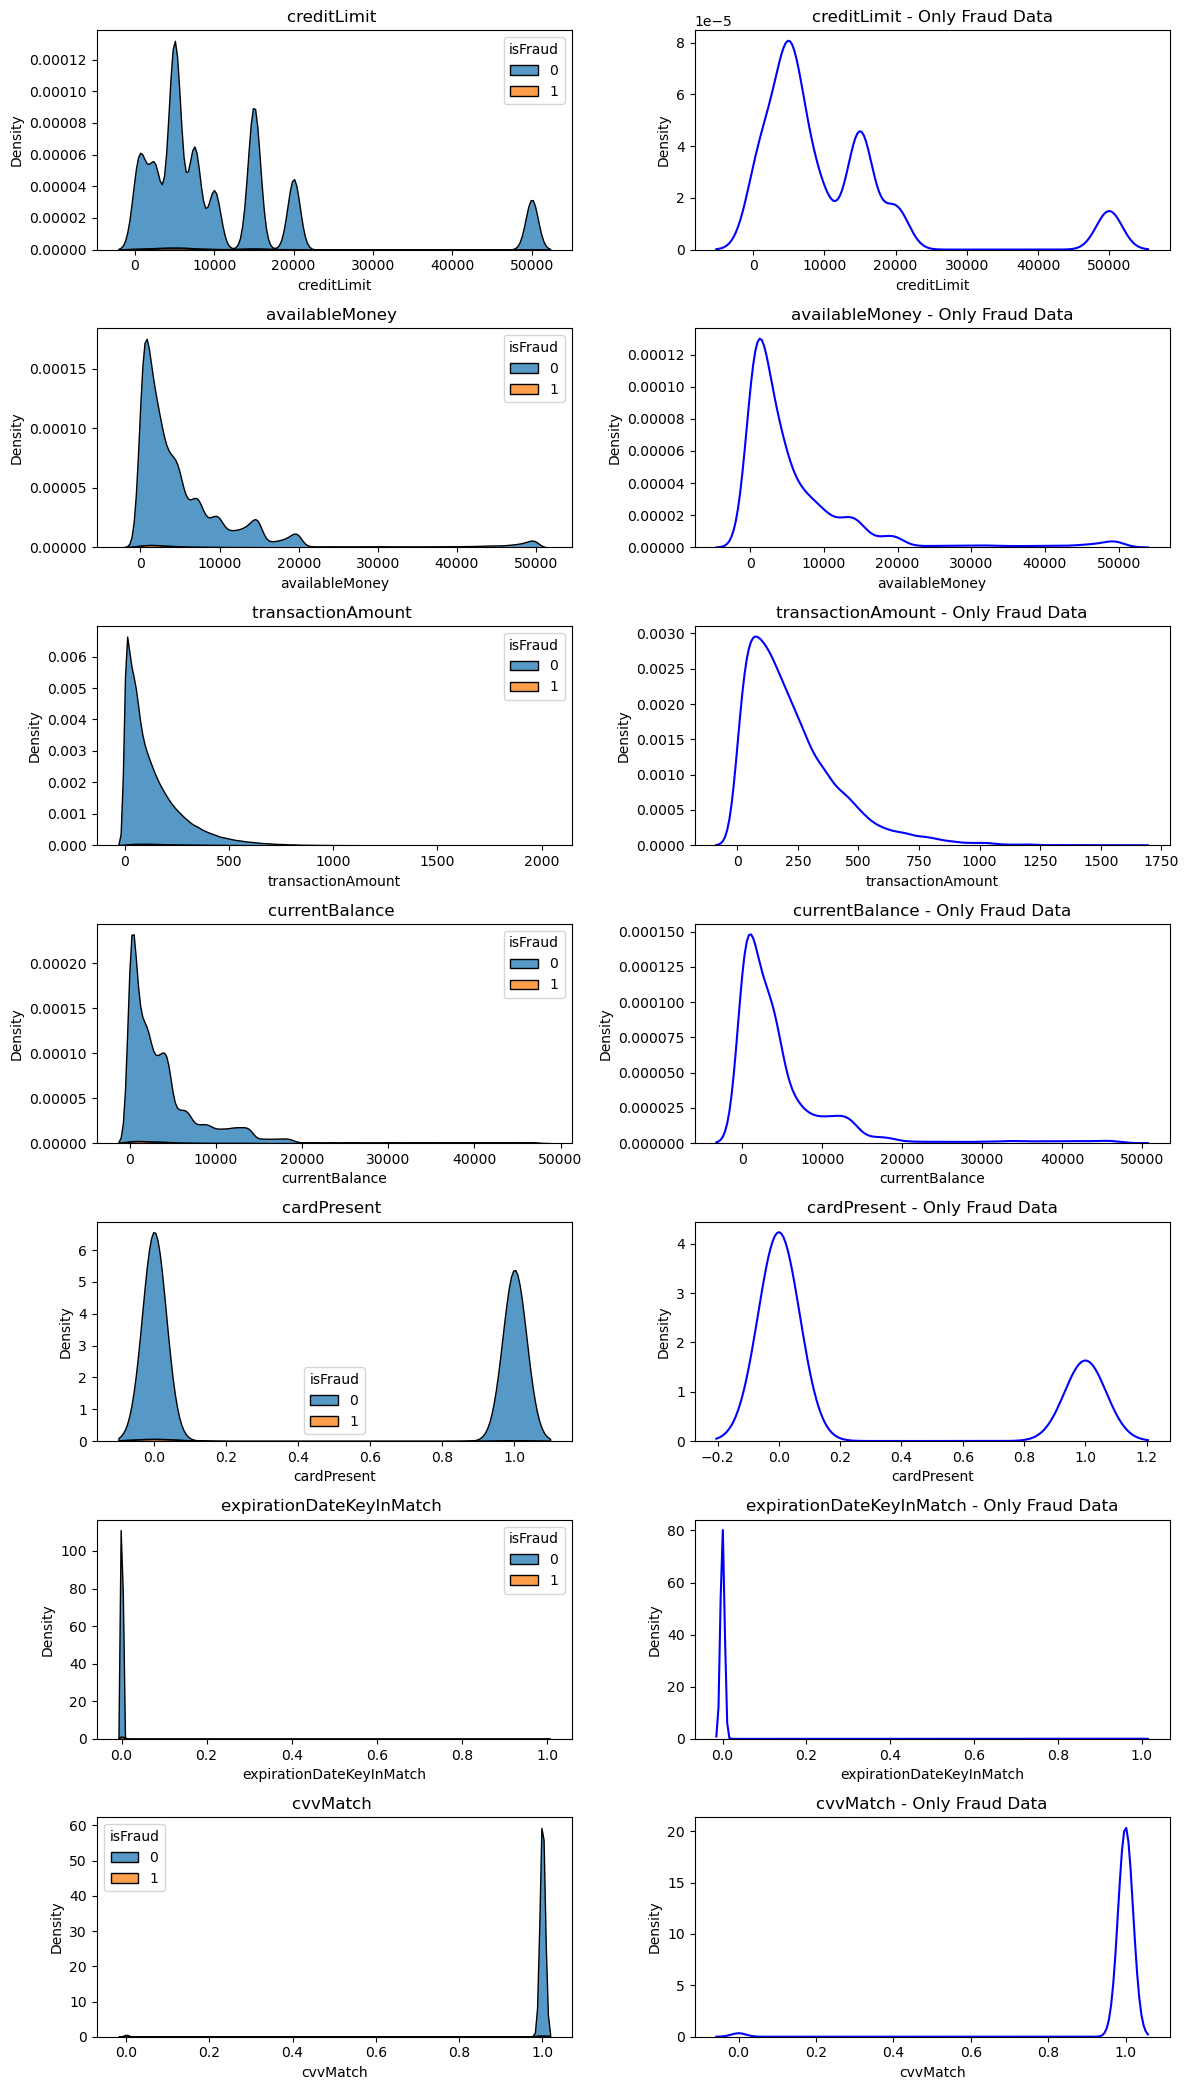

In [85]:
# Select numeric columns (int64 and float64 types)
col_num = ['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance',
       'cardPresent', 'expirationDateKeyInMatch','cvvMatch']

# Set up the overall figure
fig, ax = plt.subplots(len(col_num), 2, figsize=(12, 3 * len(col_num)))

# Flatten the axes array to make indexing easier
ax = ax.flatten()

# Loop through each numeric column
for i in range(len(col_num)):
    # KDE plot for fraud cases (True)
    sns.kdeplot(data=data, x=col_num[i],hue = "isFraud", multiple="stack",   ax=ax[2*i])
    ax[2*i].set_title(f"{col_num[i]} ")
    
    # KDE plot for non-fraud cases (False)
    sns.kdeplot(data=data[data['isFraud'] == 1], x=col_num[i], ax=ax[2*i+1], color='blue')
    ax[2*i+1].set_title(f"{col_num[i]} - Only Fraud Data")

# Adjust layout to prevent overlapping labels
plt.tight_layout()

# Show the plot
plt.show()

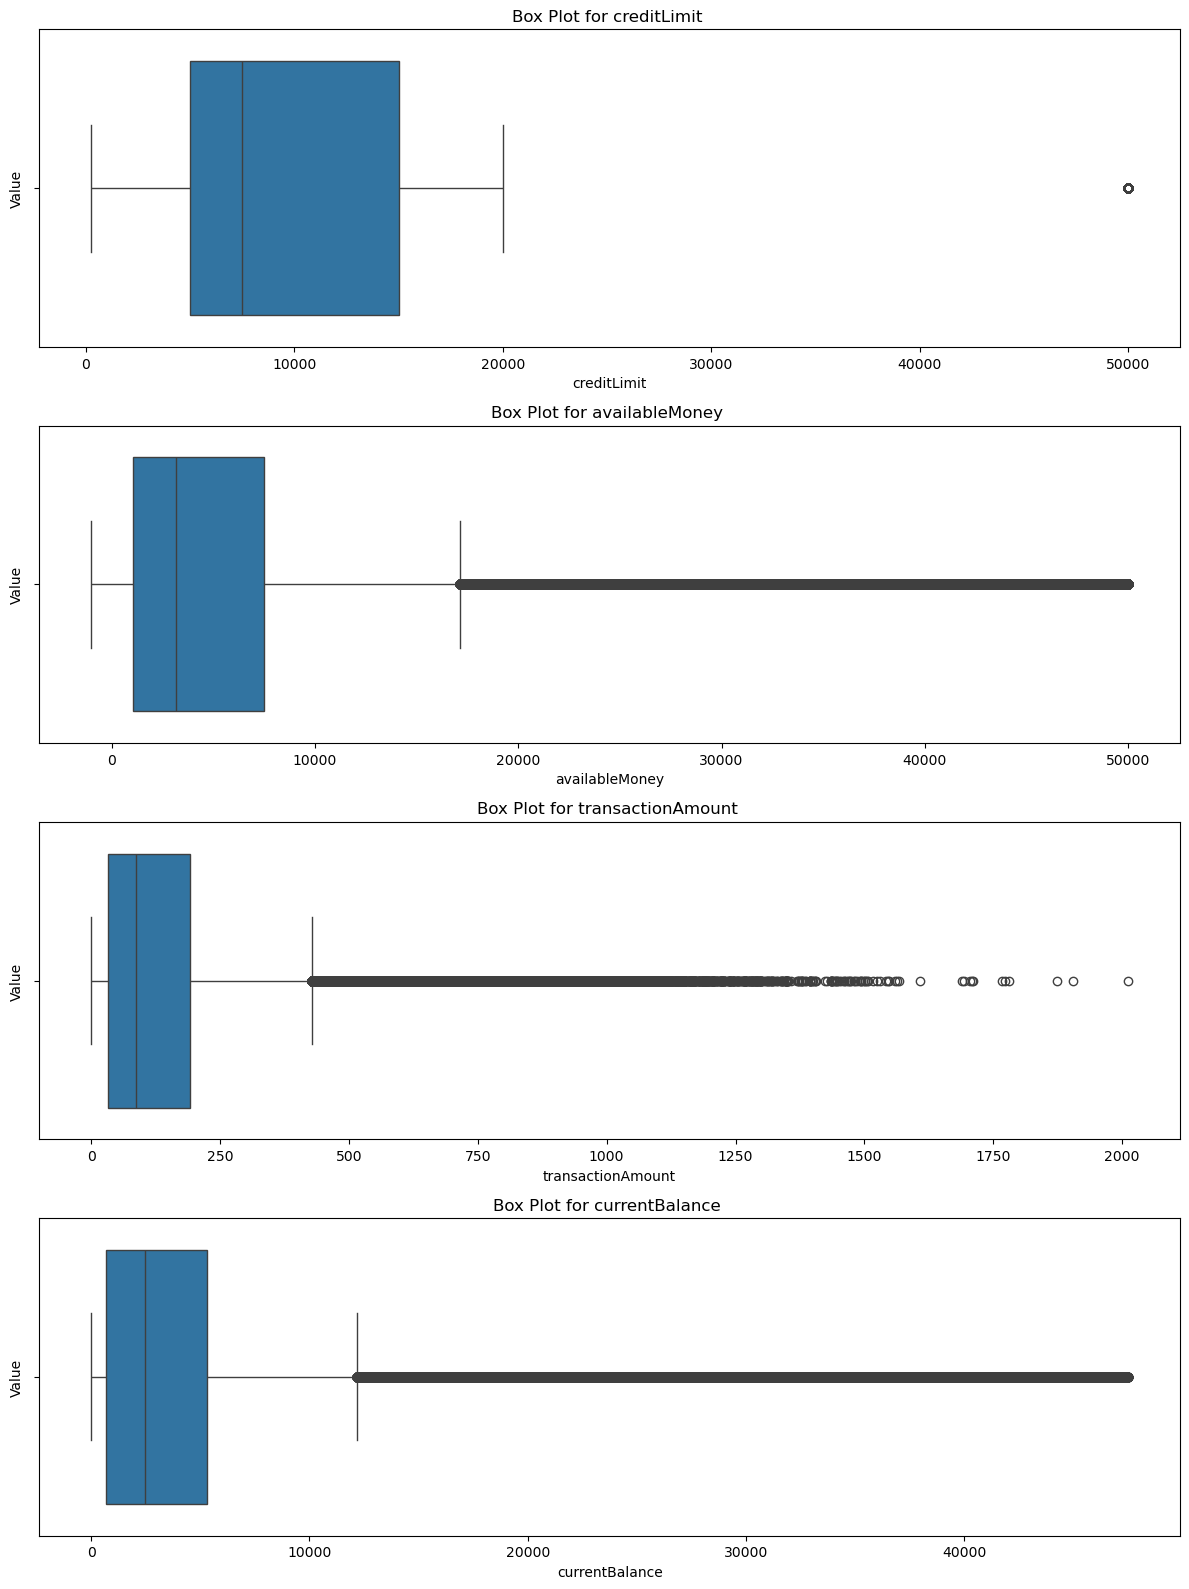

In [87]:
col_num_1 = ['creditLimit',
             'availableMoney',
             'transactionAmount',
             'currentBalance']
fig, ax = plt.subplots(len(col_num_1), 1, figsize=(12, 4 * len(col_num_1)))

# If there's only one numeric column, make `ax` iterable
if len(col_num_1) == 1:
    ax = [ax]

# Loop through each numeric column
for i, col in enumerate(col_num_1):
    sns.boxplot(data=data, x=col, ax=ax[i])
    ax[i].set_title(f"Box Plot for {col} ", fontsize=12)
    ax[i].set_xlabel(col, fontsize=10)
    ax[i].set_ylabel("Value", fontsize=10)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

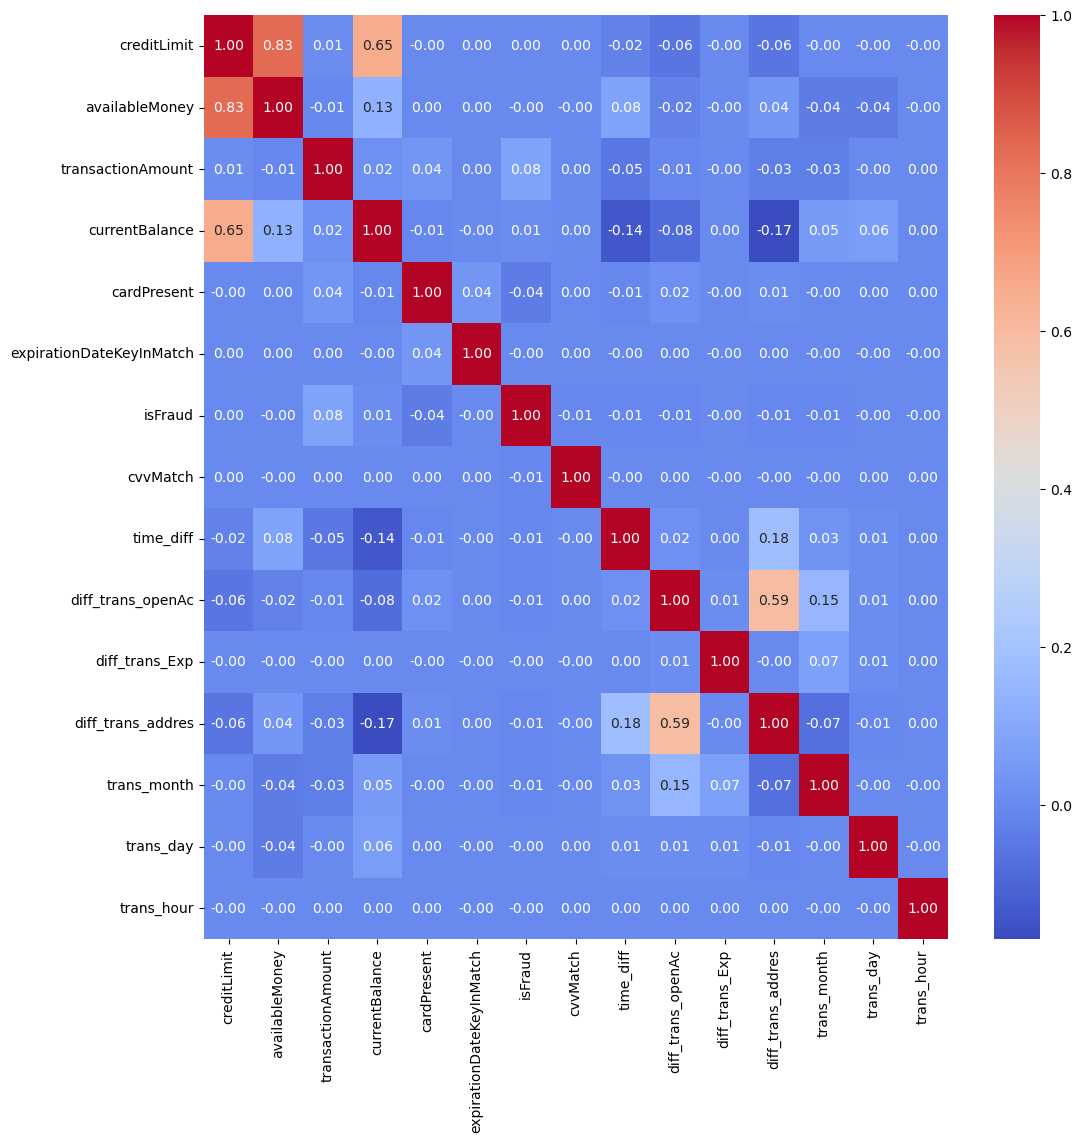

In [88]:
# Convert 'isFraud' to integer type if not already
data["isFraud"] = data['isFraud'].astype(int)

# Select numeric columns
col_num = data.select_dtypes(include=['int32', 'int64', 'float64']).columns

# Compute the correlation matrix and round it to 2 decimal places
correlation_matrix = data[col_num].corr().round(2)

# Plot the heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})

# Show the plot
plt.show()

In [90]:
data_predict = data.copy()

In [91]:
# columns with the high number of categories
data_predict[["merchantName", "merchantCategoryCode", "customerId", "cardLast4Digits"]].nunique()

merchantName            2490
merchantCategoryCode      19
customerId              5000
cardLast4Digits         5246
dtype: int64

We see that ["merchantName", "merchantCategoryCode", "customerId", "cardLast4Digits"] have the high number of categories, also customerId and cardLast4Digits do not have predictivity poewer. So I drop these two columns and for the other I only choose top 5 categories and replace other categories with Other. 

In [93]:
data_predict.drop(["customerId", "cardLast4Digits"], axis = 1 , inplace = True)
col_high_cat = ["merchantName", "merchantCategoryCode"]
for i in col_high_cat: 
    top_fraud_merch = data_predict[data_predict['isFraud'] == 1][i].value_counts().head(5).index
# Replace merchant names not in top_fraud_merch with 'other
    data_predict[i] = data_predict[i].apply(lambda x: x if x in top_fraud_merch else 'other')